### Import the libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

from sklearn.metrics import mean_squared_error,  mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

### 1. Problem Statement

Predict the trend of Bitcoin closing price using LSTM, by leveraging the historical closing price data spanning the past 5 years.


### 2. Input data

The input data is extracted from Yahoo Finance for Bitcoin (symbol = 'BTC-USD')  using yfinancefor the past 5 years in the date range from '2018-05-01' to '2023-06-14'.The .csv file for the same is loaded here.

In [2]:
df = pd.read_excel('Bitcoin_data.xlsx')
df.head(100)


,Date,Close
0,2018-04-30,9240.549805
1,2018-05-01,9119.009766
2,2018-05-02,9235.919922
3,2018-05-03,9743.860352
4,2018-05-04,9700.759766
...,...,...
95,2018-08-03,7434.390137
96,2018-08-04,7032.850098
97,2018-08-05,7068.479980
98,2018-08-06,6951.799805


In [3]:
df.shape

(1841, 2)

In [4]:
df.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [5]:
df.tail()

,Date,Close
1836,2023-05-10,27621.755859
1837,2023-05-11,27000.789062
1838,2023-05-12,26804.990234
1839,2023-05-13,26784.078125
1840,2023-05-14,26930.638672


The data has 1841 rows and both the columns are already in the desired format. So we go and check the underlying trend of the historical data.

#### 2.1 Visualizing the Closing Price

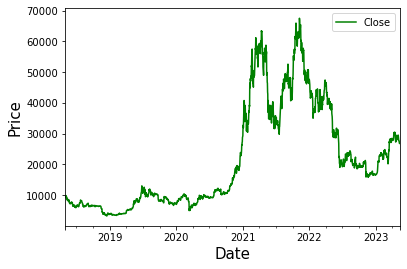

In [6]:
df.plot(x = 'Date', y='Close', label='Close',color='green')
plt.xlabel('Date',size=15)
plt.ylabel('Price',size=15)
plt.legend()
plt.show()

**Inference**: The historical data of Bitcoin exhibits an upward trend until 2021, which was subsequently followed by a period of steep decline and notable price fluctuations.

In [7]:
# Setting date column as index
df.set_index('Date',drop=True,inplace=True)
df.head()

,Close
Date,
2018-04-30,9240.549805
2018-05-01,9119.009766
2018-05-02,9235.919922
2018-05-03,9743.860352
2018-05-04,9700.759766


### 3. Data Processing

#### 3.1 - Split the data 

In this scenario, our focus will solely be on the closing prices from the dataset to train the LSTM model and date column would be used for the purpose of forecasting. To accomplish this, we will extract 80% of the closing prices from the available stock data, which will serve as our training set. and the rest of the is the test set.

In [8]:
training_size = round(len(df) * 0.80) 
training_size

1473

In [9]:
# Train set
train_data = df[:training_size]
# Test set
test_data  = df[training_size:]

# Shape of the datasets
train_data.shape, test_data.shape

((1473, 1), (368, 1))

#### 3.2 - Feature Scaling

The next step is to scale the stock prices between (0, 1) to avoid intensive computation. The common methods of feature scaling are standardization and normalization. It is recommended to take Normalization, particularly when working on RNN with a Sigmoid function in the output layer as LSTM uses sigmoid and tanh that are sensitive to magnitudes so prices should be normalized before training the model.

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data[train_data.columns] = scaler.fit_transform(train_data)

In [11]:
test_data[test_data.columns] = scaler.transform(test_data)

#### 3.3 Sliding Window Approach

A special data structure is designed using the sliging window approach to cover 50-time stamps, based on which RNN will predict the 51st price.

Here the number of past timestamps is set to 50 based on experimentation. 

Thus, X_train is a nested list, which contains lists of 50 time-stamp prices(or mini-batches).

y_train is a list of stock prices which is the next day stock price i.e the 51st value, corresponding to each of the mini batches(of lists) in X_train. 

We reshape the input data into: **(n_samples x timesteps x n_features)**

Here,

n_samples = Size of train/test set  - timesteps(i.e 50)

timesteps = 50

n_feature = 1 (For Univariate Analysis)


In [12]:

# Function to create sequence of data for training and testing

def create_sequence(dataset):
  sequences = []
  labels = []

  start_idx = 0

  for stop_idx in range(50,len(dataset)): # Selecting 50 rows at a time
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))

In [13]:
X_train, y_train = create_sequence(train_data)
X_test, y_test = create_sequence(test_data)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1423, 50, 1), (1423, 1), (318, 50, 1), (318, 1))

We won't need y-test specifically as we will be predicting the prices but, we can use the y_test set to understand the shape of prediction set

### 4. Model Building

First, we intialize a sequential model and then add the 1st LSTM layer followed by a dropout layer.

For the LSTM layer:
units - signifies number of LSTM neurons in the layer.50 neurons will give the model high dimensionality, enough to capture the upwards and downwards trends.

return_sequences=True - passes on the sequences from one LSTM layer to the second LSTM layer.

input_shape - Corresponds to the timesteps and no of features of the train set which is 50 and 1 respectively

dropout=0.2 - signifies that 20 % of the 50 neurons will be ignores randomly during each iteration of training

Dense is set to 1 since we are doing a univariate analysis and predicting the one closing price.

In [15]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))

model.add(Dropout(0.2)) 
model.add(LSTM(units=50))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


#### 4.1 Model Fitting

In [16]:
model.fit(X_train,y_train, epochs=80,validation_data=(X_test,y_test), verbose=1)

Epoch 1/80
45/45 [==============================] - 20s 135ms/step - loss: 0.0232 - mean_absolute_error: 0.0848 - val_loss: 5.9733e-04 - val_mean_absolute_error: 0.0186
Epoch 2/80
45/45 [==============================] - 3s 56ms/step - loss: 0.0020 - mean_absolute_error: 0.0266 - val_loss: 6.2660e-04 - val_mean_absolute_error: 0.0200
Epoch 3/80
45/45 [==============================] - 3s 55ms/step - loss: 0.0020 - mean_absolute_error: 0.0267 - val_loss: 4.9409e-04 - val_mean_absolute_error: 0.0164
Epoch 4/80
45/45 [==============================] - 2s 52ms/step - loss: 0.0016 - mean_absolute_error: 0.0241 - val_loss: 5.2597e-04 - val_mean_absolute_error: 0.0178
Epoch 5/80
45/45 [==============================] - 3s 58ms/step - loss: 0.0016 - mean_absolute_error: 0.0240 - val_loss: 4.3624e-04 - val_mean_absolute_error: 0.0157
Epoch 6/80
45/45 [==============================] - 2s 55ms/step - loss: 0.0016 - mean_absolute_error: 0.0243 - val_loss: 0.0010 - val_mean_absolute_error: 0.0277


### 5. Making Predictions

In [17]:
test_pred = model.predict(X_test)
test_pred[:5]

10/10 [==============================] - 3s 17ms/step


array([[0.26549178],
       [0.25969815],
       [0.25586292],
       [0.25448087],
       [0.26024592]], dtype=float32)

In [18]:
# Scaling the predictions back to the orginal scale
predicted_stock_price = scaler.inverse_transform(test_pred)


array([[20315.865],
       [19943.16 ],
       [19696.44 ],
       [19607.533],
       [19978.398],
       [20308.295],
       [20634.746],
       [21269.191],
       [21754.855],
       [21930.557],
       [21633.764],
       [20968.963],
       [20229.348],
       [20150.395],
       [20443.402],
       [20839.877],
       [21245.727],
       [21301.92 ],
       [21951.055],
       [22867.834],
       [23390.037],
       [23543.203],
       [23331.156],
       [23016.31 ],
       [22886.889],
       [22337.148],
       [21880.518],
       [22369.879],
       [23304.047],
       [23933.107],
       [24124.143],
       [23960.465],
       [23765.213],
       [23505.47 ],
       [23297.629],
       [23109.527],
       [23303.707],
       [23369.35 ],
       [23468.725],
       [23806.234],
       [23765.787],
       [23992.176],
       [24184.277],
       [24482.756],
       [24681.887],
       [24719.375],
       [24618.148],
       [24417.568],
       [24044.541],
       [23748.229],


In [35]:
# Scaling the test set value back to the orginal scale
predicted_stock_price_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

### 6. Evaluate the model performance

In [52]:
ms_error = mean_squared_error(predicted_stock_price_unscaled,predicted_stock_price)
root_ms_error = math.sqrt(ms_error)
print('Mean Squared Error (MSE): %.3f' % root_ms_error)

Mean Squared Error (MSE): 792.070


**Inference:** We have used Root Mean Square Error(RMSE) as the error metric. RMSE signifies the average distance between predicted points on the test set and the actual (true) labels. In other words, it shows the extent of our error. The less this number, the better. We can see, that our model’s RMSE is not very big (consider that the price in our data set is in thousands of USD, and we are mistaken only by tens of USD).

### 7. Result Visualization

In [19]:
final_data = pd.concat([test_data[-318:].copy(),pd.DataFrame(predicted_stock_price,columns=['Close_Predicted'],index= df.iloc[-318:].index)], axis=1)

In [20]:
# Inverse scaling
final_data[['Close']] = scaler.inverse_transform(final_data[['Close']]) 

In [21]:
final_data.head(100)

,Close,Close_Predicted
Date,,
2022-07-01,19269.367188,20315.865234
2022-07-02,19242.255859,19943.160156
2022-07-03,19297.076172,19696.439453
2022-07-04,20231.261719,19607.533203
2022-07-05,20190.115234,19978.398438
...,...,...
2022-10-04,20336.843750,19646.443359
2022-10-05,20160.716797,20074.548828
2022-10-06,19955.443359,20351.167969


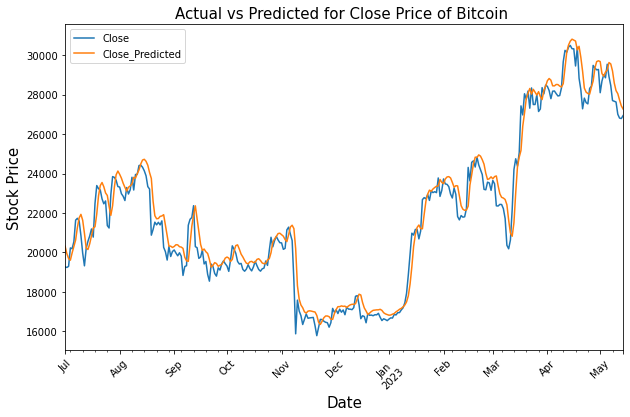

In [22]:
final_data[['Close','Close_Predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for Close Price of Bitcoin ',size=15)
plt.show()

#### From looking at the graph we can conclude that in the parts of predictions which contain spikes(especially downward spikes), the model lags behind the actual prices but in case of smooth changes or sideways trend in the price, the model manages to follow the trend well.